In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from scipy.odr import *
from scipy.optimize import *
from IPython.display import display, Math, Latex

In [5]:
def plotData(X,Y,lims=((0,10),(0,10)),mStyle='.',lStyle='',col='r',aLbl=('x','y'), ttl='Test ODR'):
    (xlims,ylims) = lims
    xlbl,ylbl = aLbl
             
    p = plot(X,Y,marker=mStyle,ls=lStyle, c=col)
    title(ttl)
    xlabel(xlbl)
    ylabel(ylbl)
    xlim(xlims)
    ylim(ylims)
    return p

# Test ODR with realistic non-linear curves (for calibration)

Above, we find code that shows us that ODR works for linear algorithms and outputs what we expect it to output.  Now we want to create a set of data that can hopefully highlight how the ODR algorithm works for a more realistic non-linear model, like the one used during soma calibration

### Define basic functions to test ODR on a known linear model

In [6]:
# Convert from Iin to iIn
def IintoiIn(Iin, Ilk, pqua, pilkr):
    return (1.*pqua*Iin*Ilk) / (Ilk+pilkr)**2

# Convert from iIn to Iin
def iIntoIin(iIn, Ilk, pqua, pilkr):
    return 1.*iIn * (Ilk+pilkr)**2 / (pqua*Ilk)

def fullFitF_tr(beta, X):
    pqua, ptau, pilkr,pref1,pref2 = beta[0], beta[1], beta[2], beta[3], beta[4]
    xVal, Ilk, Iref = X[0], X[1], X[2]
    
    Ilk = 0.1
    Iref = 5

    tmpiIn = IintoiIn(xVal,Ilk,pqua,pilkr)
    badiInMask = tmpiIn<=0.5

    tmpiIn[tmpiIn<=0.5] = 0.50000000000001
    foo = sqrt((2.*tmpiIn)-1.)
    tr = (pref1 - pref2*log(xVal*Ilk)) / Iref
    f = (1/((ptau/(Ilk + pilkr) * (pi + 2.*arctan(1./foo))/foo) + tr))
    return f

### Create data

[ 0.0369  0.0391  0.0409  0.0431  0.0449  0.0471  0.0489  0.0511  0.0529
  0.0551  0.0569  0.0591  0.0609  0.0631  0.0649  0.0671  0.0689  0.0711
  0.0729  0.0751  0.0769  0.0791  0.0809  0.0831  0.0849  0.0871  0.0889
  0.0911  0.0929  0.0951  0.0969  0.0991]
[  2.39884635   3.31974014   7.02765478   6.39058656   9.56524061
   8.61549915  11.57501537  10.46416521  13.29643598  12.08133028
  14.82586042  13.53538911  16.21413554  14.86549678  17.49226069
  16.0967523   18.68093737  17.24649765  19.7948867   18.32737222
  20.84506863  19.34896254  21.83993293  20.31876736  22.7861751
  21.24279788  23.68921884  22.12596987  24.55353791  22.97237019
  25.38287872  23.78544414]


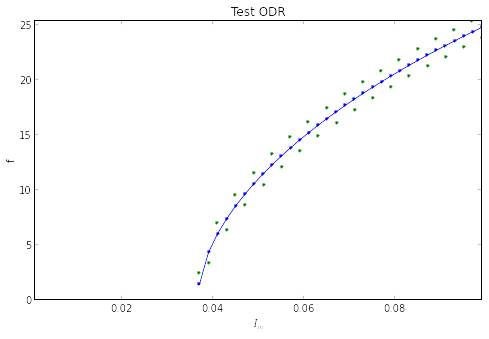

In [7]:
# Create fake data
Iins = arange(0.001,0.101,0.002)
Ilk = 0.1
Iref = 5
Xs, Ys, Zs = meshgrid(Iins,Ilk,Iref)

# Create fake skewed data
skIins = append(Iins-0.004, Iins+0.004)
skXs, skYs, skZs = meshgrid(skIins,Ilk,Iref)

# Define pVals
pqua = 1.5
ptau = 0.001
pilkr = 0.005
pref1 = 0.025
pref2 = 0.003

FRs = fullFitF_tr((pqua,ptau,pilkr,pref1,pref2),(Iins, Ilk, Iref))

# Filter out data where the value is essentially 0
mask = where(FRs>1e-5)
FRs = FRs[mask]
tmpXs = Xs.flatten()[mask]
tmpYs = Ys.flatten()[mask]
tmpZs = Zs.flatten()[mask]

# Setup data in order to plot a high-resolution theoretical curve
thIins = arange(0.001,0.101,0.0001)
thFRs = fullFitF_tr((pqua,ptau,pilkr,pref1,pref2),(thIins, Ilk, Iref))

# Skew the data
xSkew, ySkew = 0.0001, 1
skewXs = tmpXs.copy()
skewXs[0::2] -= xSkew
skewXs[1::2] += xSkew
print skewXs

skewFRs = FRs.copy()
skewFRs[0::2] += ySkew
skewFRs[1::2] -= ySkew
print skewFRs

# Plot the data
fig = figure(figsize(8,5))
plotData(tmpXs, FRs, lims=((min(Iins),max(Iins)),(min(FRs),max(FRs))), lStyle='-', col='b', aLbl=(r'$I_{in}$',r'f'))
plotData(skewXs, skewFRs, lims=((min(Iins),max(Iins)),(0,max(skewFRs))),col='g',aLbl=(r'$I_{in}$',r'f'))

### Run the ODR algorithm

In [8]:
mydata = Data(vstack((tmpXs, tmpYs, tmpZs)),FRs)
mydata = Data(vstack((skewXs, tmpYs, tmpZs)),skewFRs)
#mydata = Data(vstack((skewXs, tmpYs, tmpZs)),FRs)
model = Model(fullFitF_tr)
myodr = ODR(
    mydata, model,
    beta0=[pqua, ptau, pilkr, pref1, pref2],
    sstol=1e-10, partol=1e-12, maxit=500, taufac=1)
myfit = myodr.run()
pVals = myfit.beta

### Output the ODR Results

Print the output parameters that are found using the ODR.  In the process of doing this, also print out the calculated values of the residual variance, the sum of squared error, the sum of the squared delta (error in the x-axis) values, and the sum of the squared epsilon (error in the y-axis) values

pQua:		1.46256573672
pTau:		0.000775794257176
pIlkr:		0.00505404880604
pRef1:		-0.243646539328
pRef2:		0.0673545259099



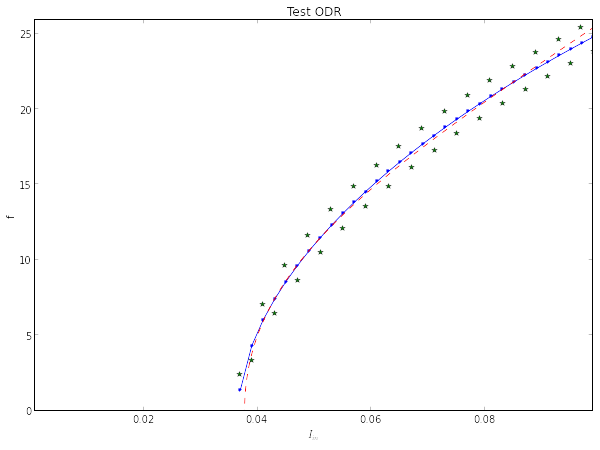

In [9]:
print 'pQua:\t\t', myfit.beta[0]
print 'pTau:\t\t', myfit.beta[1]
print 'pIlkr:\t\t', myfit.beta[2]
print 'pRef1:\t\t', myfit.beta[3]
print 'pRef2:\t\t', myfit.beta[4]
print ''

# Plot the data
fig = figure(figsize(10,7))
plotData(tmpXs, FRs, lims=((min(Iins),max(Iins)),(min(FRs),max(FRs))), lStyle='-', col='b', aLbl=(r'$I_{in}$',r'f'))
plotData(skewXs, skewFRs, lims=((min(Iins),max(Iins)),(0,max(skewFRs))),mStyle='*', col='g',aLbl=(r'$I_{in}$',r'f'))
outFRs = fullFitF_tr(myfit.beta,(thIins, Ilk, Iref))
inthFRs = fullFitF_tr((pqua,ptau,pilkr,pref1,pref2),(thIins, Ilk, Iref))
#plotData(thIins, inthFRs, lims=((min(Iins),max(Iins)),(0,max(outFRs))),mStyle='',lStyle='--',col='r',aLbl=(r'$I_{in}$',r'f'))
plotData(thIins, outFRs, lims=((min(Iins),max(Iins)),(0,max(outFRs))),mStyle='',lStyle='--',col='r',aLbl=(r'$I_{in}$',r'f'))

In [10]:
print "Delta:\t\t", myfit.delta
print "Eps:\t\t", myfit.eps
print "X+delta:\t:", myfit.xplus
print "Calc X+delta:\t", [skewXs,tmpYs,tmpZs] + myfit.delta

Delta:		[[ 0.00132389 -0.00040324  0.00151716 -0.00154122  0.00187955 -0.0021301
   0.0023894  -0.00241537  0.00294121 -0.00253474  0.00346096 -0.00258054
   0.00390034 -0.00261644  0.00422936 -0.00268615  0.00443049 -0.00281916
   0.00449467 -0.00303486  0.00441841 -0.0033454   0.00420191 -0.00375789
   0.00384771 -0.00427582  0.00335985 -0.0049002   0.00274323 -0.0056303
   0.00200324 -0.00646425]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.


In [11]:
print "Y:\t\t", myfit.y
print "Calc Y:\t\t", fullFitF_tr(myfit.beta, myfit.xplus), "\n"
print "Calc Y:\t\t", fullFitF_tr(myfit.beta,(skewXs+myfit.delta[0],tmpYs+myfit.delta[1],tmpZs+myfit.delta[2])), "\n"

Y:		[  2.39884578   3.31974037   7.02765262   6.39058852   9.56523682
   8.61550297  11.57500947  10.46417058  13.29642769  12.0813368
  14.82584973  13.53539649  16.21412266  14.86550487  17.49224602
  16.09676112  18.68092144  17.24650734  19.79487008  18.32738302
  20.84505196  19.34897478  21.83991683  20.3187814   22.78616019
  21.24281412  23.68920572  22.12598871  24.55352715  22.97239204
  25.38287083  23.78546939]
Calc Y:		[  2.39884578   3.31974037   7.02765262   6.39058852   9.56523682
   8.61550297  11.57500947  10.46417058  13.29642769  12.0813368
  14.82584973  13.53539649  16.21412266  14.86550487  17.49224602
  16.09676112  18.68092144  17.24650734  19.79487008  18.32738302
  20.84505196  19.34897478  21.83991683  20.3187814   22.78616019
  21.24281412  23.68920572  22.12598871  24.55352715  22.97239204
  25.38287083  23.78546939] 

Calc Y:		[  2.39884578   3.31974037   7.02765262   6.39058852   9.56523682
   8.61550297  11.57500947  10.46417058  13.29642769  12.0813368

In [12]:
print "Orthogonal Error Sq:\t", myfit.delta**2+myfit.eps**2
print "Orthogonal Error:\t", sqrt(myfit.delta**2+myfit.eps**2), "\n"

Orthogonal Error Sq:	[[  1.75267349e-06   1.62599546e-07   2.30177230e-06   2.37536423e-06
    3.53273573e-06   4.53736010e-06   5.70927378e-06   5.83404571e-06
    8.65079439e-06   6.42496313e-06   1.19783359e-05   6.65925533e-06
    1.52128497e-05   6.84583400e-06   1.78876714e-05   7.21547416e-06
    1.96295143e-05   7.94777736e-06   2.02023510e-05   9.21047289e-06
    1.95226657e-05   1.11918742e-05   1.76563105e-05   1.41219238e-05
    1.48051129e-05   1.82828795e-05   1.12887690e-05   2.40122790e-05
    7.52544746e-06   3.17007998e-05   4.01304865e-06   4.17871016e-05]
 [  3.27053673e-13   5.60654342e-14   4.66310431e-12   3.84079468e-12
    1.43732252e-11   1.45911795e-11   3.47400120e-11   2.87743292e-11
    6.86008649e-11   4.25160360e-11   1.14277767e-10   5.44767487e-11
    1.65848150e-10   6.55538659e-11   2.15128690e-10   7.78330607e-11
    2.53987566e-10   9.39185445e-11   2.76104152e-10   1.16769031e-10
    2.77954566e-10   1.49823209e-10   2.59120956e-10   1.97169252e-1

In [25]:
print "Res. Var:\t",myfit.res_var
print "Calc Res. Var:\t",sum(myfit.delta[0]**2+myfit.delta[1]**2+myfit.delta[2]**2+myfit.eps**2)/(len(myfit.eps)-5)
print "Calc Res. Var:\t",sum(myfit.delta**2+myfit.eps**2)/(len(myfit.eps)-5)

Res. Var:	1.40733085394e-05
Calc Res. Var:	1.40733085394e-05
Calc Res. Var:	1.40736667707e-05


In [16]:
print myfit.delta[0]
print myfit.delta[1]
print myfit.delta[2]
print myfit.eps
print myfit.delta[0]**2
print myfit.delta[1]**2
print myfit.delta[2]**2
print myfit.eps**2
print myfit.delta[0]**2 + myfit.eps**2

[ 0.00132389 -0.00040324  0.00151716 -0.00154122  0.00187955 -0.0021301
  0.0023894  -0.00241537  0.00294121 -0.00253474  0.00346096 -0.00258054
  0.00390034 -0.00261644  0.00422936 -0.00268615  0.00443049 -0.00281916
  0.00449467 -0.00303486  0.00441841 -0.0033454   0.00420191 -0.00375789
  0.00384771 -0.00427582  0.00335985 -0.0049002   0.00274323 -0.0056303
  0.00200324 -0.00646425]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ -5.71886066e-07   2.36781406e-07  -2.15942222e-06   1.95979455e-06
  -3.79120366e-06   3.81984025e-06  -5.89406583e-06   5.36417088e-06
  -8.28256391e-06   6.52043220e-06  -1.06900780e-05   7.38083659e-06
  -1.28782045e-05   8.09653419e-06  -1.46672659e-05   8.82230472e-06
  -1.59369874e-05   9.69115806e-06  -1.66163820e-05   1.08059720e-05
  -1

In [17]:
rsd = sqrt(myfit.res_var)/sqrt(sum(myfit.y**2)/(len(myfit.y)-2))
print "Rel. Std. Dev:\t", rsd
print "Calc. Rel Error:\t", sqrt(myfit.sum_square/(len(myfit.delta)-2))/sqrt(sum(myfit.y**2)/(len(myfit.y)-2))
print ""

print "Sum[e^2]:\t", myfit.sum_square
print "Calc_Sum[e^2]:\t", sum(myfit.delta**2+myfit.eps**2)
print "Sum[delta^2]:\t\t", myfit.sum_square_delta
print "Calc_Sum[delta^2]:\t", sum(myfit.delta**2)
print "Sum[eps^2]:\t\t", myfit.sum_square_eps
print "Calc_Sum[eps^2]:\t", sum(myfit.eps**2)
print "Rel Error:\t",myfit.rel_error

Rel. Std. Dev:	0.00020835265587
Calc. Rel Error:	0.00108263215757

Sum[e^2]:	0.000379979330564
Calc_Sum[e^2]:	0.000379989002808
Sum[delta^2]:		0.000379974494441
Calc_Sum[delta^2]:	0.000379974494441
Sum[eps^2]:		4.83612236043e-09
Calc_Sum[eps^2]:	4.83612236043e-09
Rel Error:	3.47541214894e-12


# Scratch Pad

This section below here is for me to play around and see how things work and/or what things are without needing to document it in my code above

I'm playing around with what the "work" array is about.  It appears that it's an array of output values indexed by the dictionary "work_ind".  This array of output values can help debug more information if I am able to decode what all of the key values mean

In [18]:
print len(myfit.work), myfit.work_ind
print myfit.stopreason
print myfit.work[6:12]
print myfit.work[myfit.work_ind['eps']:myfit.work_ind['xplus']]

1341 {'tau': 293, 'rnors': 297, 'qraux': 338, 'prers': 298, 'wssep': 289, 'diff': 541, 'rcond': 290, 'delts': 549, 'wrk7': 1335, 'fjacd': 934, 'tt': 837, 'partl': 299, 's': 323, 'fjacb': 380, 'rvar': 286, 'wrk6': 1175, 'u': 343, 'sstol': 300, 'wrk5': 1172, 'wrk2': 1126, 'wrk3': 1158, 'wrk1': 1030, 'fs': 348, 'wssde': 288, 'taufc': 301, 'pnorm': 296, 'olmav': 292, 'we1': 540, 'delta': 0, 'deltn': 645, 'alpha': 294, 'ssf': 333, 'omega': 933, 'wrk4': 1163, 'fn': 224, 'betac': 308, 'betao': 303, 'betan': 318, 'eps': 96, 'xplus': 128, 'ss': 328, 'wss': 287, 'eta': 291, 'betas': 313, 't': 741, 'actrs': 295, 'apsma': 302, 'sd': 261}
['Sum of squares convergence']
[ 0.0023894  -0.00241537  0.00294121 -0.00253474  0.00346096 -0.00258054]
[ -5.71886066e-07   2.36781406e-07  -2.15942222e-06   1.95979455e-06
  -3.79120366e-06   3.81984025e-06  -5.89406583e-06   5.36417088e-06
  -8.28256391e-06   6.52043220e-06  -1.06900780e-05   7.38083659e-06
  -1.28782045e-05   8.09653419e-06  -1.46672659e-05   

In [19]:
foo = array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0.45, 0.5, 0.6, 0.6, 0.3, 0.7, 0.8])
print foo

[ 1.    1.    1.    1.    1.    1.    1.    1.    1.    0.45  0.5   0.6
  0.6   0.3   0.7   0.8 ]


In [20]:
print foo[foo<0.5]

[ 0.45  0.3 ]
